# Exploratory Data Analysis

## Import Module

In [2]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 480.9 kB/s eta 0:00:00a 0:00:01


In [3]:
import os
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import *
import pandas as pd
from datetime import datetime
import pyarrow
from pyarrow import flight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

## Extract Data from Dremio Warehouse

Create Dremio Client

In [4]:
class DremioClient:
    def __init__(self, host, port, uid, pwd) -> None:
        self._host = host
        self._port = port
        self._uid = uid
        self._pwd = pwd

    def connect(self):
        self._client = flight.FlightClient(f"grpc://{self._host}:{self._port}")

    def authenticate(self):
        bearer_token = self._client.authenticate_basic_token(
            self._uid, self._pwd)
        options = flight.FlightCallOptions(headers=[bearer_token])
        return options

    def query(self, sql, options):
        info = self._client.get_flight_info(
            flight.FlightDescriptor.for_command(sql), options=options)
        reader = self._client.do_get(info.endpoints[0].ticket, options=options)
        df = reader.read_all().to_pandas()
        return df

Now load Tracks, Track_features, artists, albums and genres table from dremio 

In [5]:
# Get env
host = os.getenv("DREMIO_HOST")
user = os.getenv("DREMIO_USER")
port = os.getenv("DREMIO_PORT")
pwd = os.getenv("DREMIO_PASSWORD")
client = DremioClient(host, port, user, pwd)
client.connect()
options = client.authenticate()

In [6]:
# Get data
# artist
table = "artist"
sql = f"SELECT * FROM home.{table}"
data_artist = client.query(sql, options)

# albums
table = "album"
sql = f"SELECT * FROM home.{table}"
data_album = client.query(sql, options)

# Track
table = "track"
sql = f"SELECT * FROM home.{table}"
data_track = client.query(sql, options)

# Track feature
table = "track_feat"
sql = f"SELECT * FROM home.{table}"
data_track_feat = client.query(sql, options)

# Genre
table = "genre"
sql = f"SELECT * FROM home.{table}"
data_genre = client.query(sql, options)

Lets see our data

In [6]:
# Artist
data_artist

,external_urls,followers,id,name,popularity,image_url,artist_id
0,https://open.spotify.com/artist/4QQgXkCYTt3BlE...,4116049,None,"Earth, Wind & Fire",70,https://i.scdn.co/image/ab6761610000e5eb9722e1...,4QQgXkCYTt3BlENzhyNETg
1,https://open.spotify.com/artist/1l2ekx5skC4gJH...,1825107,None,Don Diablo,63,https://i.scdn.co/image/ab6761610000e5eb06e968...,1l2ekx5skC4gJH8djERwh1
2,https://open.spotify.com/artist/757aE44tKEUQEq...,10076234,None,Roddy Ricch,75,https://i.scdn.co/image/ab6761610000e5eb9c30c6...,757aE44tKEUQEqRuT6GnEB
3,https://open.spotify.com/artist/487N2T9nIPEHrl...,19333818,None,Zé Neto & Cristiano,77,https://i.scdn.co/image/ab6761610000e5eb1bb920...,487N2T9nIPEHrlTZLL3SQs
4,https://open.spotify.com/artist/1EXjXQpDx2pROy...,3695306,None,Melendi,72,https://i.scdn.co/image/ab6761610000e5eb69b929...,1EXjXQpDx2pROygh8zvHs4
...,...,...,...,...,...,...,...
992,https://open.spotify.com/artist/3eqjTLE0HfPfh7...,5987583,None,Bruce Springsteen,74,https://i.scdn.co/image/ab6761610000e5ebf7cac4...,3eqjTLE0HfPfh78zjh6TqT
993,https://open.spotify.com/artist/5KNNVgR6LBIABR...,1458749,None,Dermot Kennedy,70,https://i.scdn.co/image/ab6761610000e5eb2cd8d0...,5KNNVgR6LBIABRIomyCwKJ
994,https://open.spotify.com/artist/4lDBihdpMlOalx...,73910,None,Grey,63,https://i.scdn.co/image/ab6761610000e5eb6f0ae1...,4lDBihdpMlOalxy1jkUbPl
995,https://open.spotify.com/artist/2VYQTNDsvvKN9w...,4181282,None,Marilyn Manson,67,https://i.scdn.co/image/ab6761610000e5eb9e2dae...,2VYQTNDsvvKN9wmU5W7xpj


In [7]:
#data  album
data_album

,album_type,external_urls,id,label,name,popularity,release_date,release_date_precision,total_tracks,artist_id,image_url,album_id
0,single,https://open.spotify.com/album/5nqsQ0kfgdhrN8i...,None,Rimas Entertainment LLC,100 MILLONES,55,2021-05-28,day,1,4q3ewBCX7sLwd24euuV69X,https://i.scdn.co/image/ab67616d0000b273e7330f...,5nqsQ0kfgdhrN8is8FR2rP
1,single,https://open.spotify.com/album/6aq5eEl7b51s5OU...,None,South Coast Music Group/Capitol Records,Favorite Song (with Khalid) [Remix],48,2023-05-05,day,1,6LuN9FCkKOj5PcnpouEgny,https://i.scdn.co/image/ab67616d0000b273c91114...,6aq5eEl7b51s5OUYV8ve6b
2,album,https://open.spotify.com/album/2EowTulHWqSY6QZ...,None,UMC (Universal Music Catalogue),Live At The BBC (Remastered),48,1994-11-30,day,71,3WrFJ7ztbogyGnTHbHJFl2,https://i.scdn.co/image/ab67616d0000b273c4821a...,2EowTulHWqSY6QZfTDf5vW
3,album,https://open.spotify.com/album/0ETFjACtuP2ADo6...,None,EMI Catalogue,Abbey Road (Remastered),82,1969-09-26,day,17,3WrFJ7ztbogyGnTHbHJFl2,https://i.scdn.co/image/ab67616d0000b273dc3058...,0ETFjACtuP2ADo6LFhL6HN
4,album,https://open.spotify.com/album/6FED8aeieEnUWwQ...,None,Quality Control Music - Epic,"Huncho Jack, Jack Huncho",66,2017-12-21,day,13,0VRj0yCOv2FXJNP47XQnx5,https://i.scdn.co/image/ab67616d0000b273631973...,6FED8aeieEnUWwQqAO9zT1
...,...,...,...,...,...,...,...,...,...,...,...,...
19825,compilation,https://open.spotify.com/album/4piOTKXEJqN0Mik...,None,Warner Music Group - X5 Music Group,Rewrite The Stars - Movie Hits,19,2021-12-03,day,65,5F1aoppMtU3OMiltO8ymJ2,https://i.scdn.co/image/ab67616d0000b273608f84...,4piOTKXEJqN0MikQ0seu7z
19826,single,https://open.spotify.com/album/3e5NCHL38YyuUOS...,None,"Ultra Records, LLC",Hey Love,2,2020-08-14,day,1,1GLtl8uqKmnyCWxHmw9tL4,https://i.scdn.co/image/ab67616d0000b2737c86c3...,3e5NCHL38YyuUOS4GESMOL
19827,album,https://open.spotify.com/album/69YLD3zIxQt55bH...,None,Decca (UMO),All My Demons Greeting Me As A Friend (Deluxe),56,2016-08-26,day,20,1WgXqy2Dd70QQOU7Ay074N,https://i.scdn.co/image/ab67616d0000b273bb60dc...,69YLD3zIxQt55bHjVlhLTP
19828,single,https://open.spotify.com/album/4xKMB1JaAsfhHKQ...,None,Fundacion El Canserbero,Na,51,2015-05-04,day,1,1wGIhYkKWSq4yACtTkCkSX,https://i.scdn.co/image/ab67616d0000b27332b2e2...,4xKMB1JaAsfhHKQT3yuWgQ


In [8]:
#dat  track
data_track

,disc_number,explicit,external_urls,id,name,popularity,preview_url,track_number,artist_id,album_id,track_id
0,1,True,https://open.spotify.com/track/5wTRsfZKeaQnQn8...,None,305 To My City,47,None,11,3TVXtAsR1Inumwj472S9r4,2ZUFSbIkmFkGag000RWOpA,5wTRsfZKeaQnQn8JeW8QYQ
1,1,False,https://open.spotify.com/track/2Iv6YBslkxslMJQ...,None,CANTARES DE NAVIDAD,57,https://p.scdn.co/mp3-preview/77fe809150d29267...,16,5TphiK6LsT4X5NOZxq3NJB,2d9BCZeAAhiZWPpbX9aPCW,2Iv6YBslkxslMJQsxshZh5
2,1,True,https://open.spotify.com/track/2n7ohqg1s68ToAH...,None,Vete,75,https://p.scdn.co/mp3-preview/f29531b775ce0a98...,10,4q3ewBCX7sLwd24euuV69X,5lJqux7orBlA1QzyiBGti1,2n7ohqg1s68ToAHh4u9mcW
3,1,False,https://open.spotify.com/track/6GXgd1BPD9bUpqw...,None,All You Had To Do Was Stay (Taylor's Version),83,None,5,06HL4z0CvFAxyc27GXpf02,64LU4c1nfjz1t4VnGhagcg,6GXgd1BPD9bUpqw5AntGV5
4,1,True,https://open.spotify.com/track/4ZYGm4xWPhsZVij...,None,Starboy - Live,55,None,12,1Xyo4u8uXC1ZmMpatF05PJ,1OARrXe5sB0gyy3MhQ8h92,4ZYGm4xWPhsZVijqtpWn4C
...,...,...,...,...,...,...,...,...,...,...,...
172473,1,False,https://open.spotify.com/track/1OmVQd1NR9at8GS...,None,Hung Up and Overdue,26,https://p.scdn.co/mp3-preview/9c8d5b471a1349bc...,25,2UZMlIwnkgAEDBsw1Rejkn,2s7jw1QyMFXe1fsSzla8cv,1OmVQd1NR9at8GS4Sjqerf
172474,1,False,https://open.spotify.com/track/0l3BU1iDZmAuDNV...,None,Right Place Right Time - Thomas Gandey Club Mix,4,https://p.scdn.co/mp3-preview/3ba8b184c8858aa5...,12,3whuHq0yGx60atvA2RCVRW,0Ryig5U2nqKnEqIwYZREGV,0l3BU1iDZmAuDNVqbvX6vc
172475,1,True,https://open.spotify.com/track/5xtK2Y3B1R3MLeX...,None,Thas What Hoes Do (feat. Yg & Rimpau),7,https://p.scdn.co/mp3-preview/3ab2a3707c931266...,4,0EeQBlQJFiAfJeVN2vT9s0,7HVilT6l3oDge4vqlRegfW,5xtK2Y3B1R3MLeXo1bl9C7
172476,1,False,https://open.spotify.com/track/17eJyYLIlMNlOqc...,None,Lago en el Cielo,68,https://p.scdn.co/mp3-preview/c3da35ef00349e3c...,7,1QOmebWGB6FdFtW7Bo3F0W,7KHNK7l8peO0t95I1v7BmP,17eJyYLIlMNlOqcwHYJ9F2


In [9]:
#data track_feature
data_track_feat

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,track_id
0,0.595,0.656,0,-7.343,1,0.0370,0.04100,0.000000,0.1220,0.191,99.994,None,229478,4,6IG3sQ8s9nfk6TUlVzRhbN
1,0.613,0.581,0,-8.588,0,0.0424,0.53700,0.000345,0.2500,0.551,130.033,None,239560,4,4R2kfaDFhslZEMJqAFNpdd
2,0.354,0.267,1,-13.690,1,0.0281,0.73100,0.000402,0.0858,0.113,94.219,None,289749,4,08fa9LFcFBTcilB3iq2e2A
3,0.789,0.634,7,-4.762,1,0.0323,0.03480,0.000002,0.3020,0.658,116.992,None,212600,4,3YLA3NgzFRRa7LiHMtFPby
4,0.483,0.548,4,-6.291,1,0.0254,0.00471,0.000002,0.0997,0.217,79.926,None,223920,4,5hiqtrACtMJkNpaNHj0n9Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170213,0.649,0.445,7,-9.843,1,0.0327,0.07520,0.832000,0.1720,0.493,97.013,None,347640,4,3mfFIPreNFEYKxbRbmRRRo
170214,0.772,0.643,0,-6.240,0,0.0630,0.01020,0.000000,0.0705,0.669,114.031,None,206280,4,16b5bnORX3gNNDK2ar0Yo2
170215,0.604,0.788,0,-3.673,0,0.1030,0.06780,0.153000,0.1270,0.301,126.060,None,245040,4,3WTASWGNwcfCU0P9kHgFLs
170216,0.534,0.783,8,-3.593,1,0.0340,0.20600,0.005710,0.1060,0.615,92.147,None,238627,4,3lc3m1udM2lWUNfvUjjhs2


In [10]:
#data genre
data_genre

,id,genre,artist_id
0,None,atl hip hop,0VRj0yCOv2FXJNP47XQnx5
1,None,contemporary country,718COspgdWOnwOFpJHRZHS
2,None,sertanejo universitario,3p7PcrEHaaKLJnPUGOtRlT
3,None,australian pop,3WGpXCj9YhhfX11TToZcXP
4,None,pop punk,7FBcuc1gsnv6Y1nwFtNRCb
...,...,...,...
3498,None,modern rock,0epOFNiUfyON9EYx7Tpr6V
3499,None,ranchera,4PPoI9LuYeFX8V674Z1R6l
3500,None,operatic pop,0Y8KmFkKOgJybpVobn1onU
3501,None,ska mexicano,0EdvGhlC1FkGItLOWQzG4J


In [11]:
##data_info 
data = [data_artist,data_album,data_track,data_track_feat,data_genre]
def info_data(data):
    for df in data:
        if df is data_album:
            print("Data from data_album:")
        elif df is data_artist:
            print("Data from data_artist:")
        elif df is data_genre:
            print("Data from data_genre:")
        elif df is data_track:
            print("Data from data_track:")
        else:
            print("Data from data_feature:")

        print(df.info())
        print("\n")
info_data(data)


Data from data_artist:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   external_urls  997 non-null    object
 1   followers      997 non-null    int32 
 2   id             0 non-null      object
 3   name           997 non-null    object
 4   popularity     997 non-null    int32 
 5   image_url      997 non-null    object
 6   artist_id      997 non-null    object
dtypes: int32(2), object(5)
memory usage: 46.9+ KB
None


Data from data_album:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19830 entries, 0 to 19829
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   album_type              19830 non-null  object
 1   external_urls           19830 non-null  object
 2   id                      0 non-null      object
 3   label                   19830 no

In [12]:
##Check missing_data of dataframes
def missing_data(data):
    for df in data:
        if df is data_album:
            print("Data from data_album:")
        elif df is data_artist:
            print("Data from data_artist:")
        elif df is data_genre:
            print("Data from data_genre:")
        elif df is data_track:
            print("Data from data_track:")
        else:
            print("Data from data_track_feature:")

        print(df.isna().sum())
        print("\n")
missing_data(data)

Data from data_artist:
external_urls      0
followers          0
id               997
name               0
popularity         0
image_url          0
artist_id          0
dtype: int64


Data from data_album:
album_type                    0
external_urls                 0
id                        19830
label                         0
name                          0
popularity                    0
release_date                  0
release_date_precision        0
total_tracks                  0
artist_id                     0
image_url                     1
album_id                      0
dtype: int64


Data from data_track:
disc_number           0
explicit              0
external_urls         0
id               172478
name                  0
popularity            0
preview_url       58691
track_number          0
artist_id             0
album_id              0
track_id              0
dtype: int64


Data from data_track_feature:
danceability             0
energy                   0
key      

In [13]:
##Check error of missing data  
# Duyệt qua từng thành phần trong danh sách
for df in data:
    # Kiểm tra xem cột 'id' có tồn tại trong DataFrame hay không
    if 'id' in df.columns:
        # Xóa cột 'id'
        df.drop(columns=['id'], inplace=True)
## Check of missing value 
missing_data(data)

    

Data from data_artist:
external_urls    0
followers        0
name             0
popularity       0
image_url        0
artist_id        0
dtype: int64


Data from data_album:
album_type                0
external_urls             0
label                     0
name                      0
popularity                0
release_date              0
release_date_precision    0
total_tracks              0
artist_id                 0
image_url                 1
album_id                  0
dtype: int64


Data from data_track:
disc_number          0
explicit             0
external_urls        0
name                 0
popularity           0
preview_url      58691
track_number         0
artist_id            0
album_id             0
track_id             0
dtype: int64


Data from data_track_feature:
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence 

In [14]:
##Drop na (because this na feature contains 1-2% precent 


In [15]:
##I wrote 'None' because there are some songs with copyright restrictions, and it's not possible to retrieve the preview_url


def handle_missing_preview_url(data_track):
    
    # Kiểm tra xem cột 'preview_url' có tồn tại không
    if 'preview_url' in data_track.columns:
        # Thay thế giá trị thiếu bằng 'None'
        data_track['preview_url'].fillna('None', inplace=True)

    return data_track
missing_data(data)




Data from data_artist:
external_urls    0
followers        0
name             0
popularity       0
image_url        0
artist_id        0
dtype: int64


Data from data_album:
album_type                0
external_urls             0
label                     0
name                      0
popularity                0
release_date              0
release_date_precision    0
total_tracks              0
artist_id                 0
image_url                 1
album_id                  0
dtype: int64


Data from data_track:
disc_number          0
explicit             0
external_urls        0
name                 0
popularity           0
preview_url      58691
track_number         0
artist_id            0
album_id             0
track_id             0
dtype: int64


Data from data_track_feature:
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence 

In [16]:
##Check_duplicate
def duplicate_data(data):
    for df in data:
        duplicate_rows = df[df.duplicated()]
        print(duplicate_rows)
        df.drop_duplicates(inplace=True)
duplicate_data(data)


Empty DataFrame
Columns: [external_urls, followers, name, popularity, image_url, artist_id]
Index: []
Empty DataFrame
Columns: [album_type, external_urls, label, name, popularity, release_date, release_date_precision, total_tracks, artist_id, image_url, album_id]
Index: []
Empty DataFrame
Columns: [disc_number, explicit, external_urls, name, popularity, preview_url, track_number, artist_id, album_id, track_id]
Index: []
Empty DataFrame
Columns: [danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, track_id]
Index: []
Empty DataFrame
Columns: [genre, artist_id]
Index: []


In [17]:
##Check dtype of dataframe
def dtype_data(data):
    for df in data:
        if df is data_album:
            print("Data from data_album:")
        elif df is data_artist:
            print("Data from data_artist:")
        elif df is data_genre:
            print("Data from data_genre:")
        elif df is data_track:
            print("Data from data_track:")
        else:
            print("Data from data_track_feature:")
        print(df.dtypes)
        print("\n")
dtype_data(data)

Data from data_artist:
external_urls    object
followers         int32
name             object
popularity        int32
image_url        object
artist_id        object
dtype: object


Data from data_album:
album_type                object
external_urls             object
label                     object
name                      object
popularity                 int32
release_date              object
release_date_precision    object
total_tracks               int32
artist_id                 object
image_url                 object
album_id                  object
dtype: object


Data from data_track:
disc_number       int32
explicit           bool
external_urls    object
name             object
popularity        int32
preview_url      object
track_number      int32
artist_id        object
album_id         object
track_id         object
dtype: object


Data from data_track_feature:
danceability        float64
energy              float64
key                   int32
loudness            floa

In [18]:
##Check describe_data()

def describe_data(data):

    for df in data:
        if df is data_album:
            print("Data from data_album:")
        elif df is data_artist:
            print("Data from data_artist:")
        elif df is data_genre:
            print("Data from data_genre:")
        elif df is data_track:
            print("Data from data_track:")
        else:
            print("Data from data_track_feature:")
        print(df.describe())
        print("\n")
describe_data(data)
    

Data from data_artist:
          followers  popularity
count  9.970000e+02  997.000000
mean   8.071850e+06   72.687061
std    1.173949e+07    6.239559
min    2.153500e+04   26.000000
25%    2.464080e+06   68.000000
50%    4.832824e+06   72.000000
75%    8.479818e+06   76.000000
max    1.158047e+08  100.000000


Data from data_album:
         popularity  total_tracks
count  19830.000000  19830.000000
mean      45.008321      9.704286
std       18.003132     12.239651
min        0.000000      1.000000
25%       32.000000      1.000000
50%       45.000000      7.000000
75%       58.000000     14.000000
max      100.000000    216.000000


Data from data_track:
         disc_number     popularity   track_number
count  172478.000000  172478.000000  172478.000000
mean        1.059845      34.649132       8.189566
std         0.264322      17.941008       6.017409
min         1.000000       0.000000       1.000000
25%         1.000000      22.000000       3.000000
50%         1.000000      34.

In [19]:
data_track_pop=data_track[['track_id','popularity']]

track_feature_merge=data_track_feat.merge(data_track_pop,on='track_id')
corr_data = track_feature_merge.loc[:, ~track_feature_merge.columns.isin(['track_id'])]

In [20]:
corr_data


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,0.595,0.656,0,-7.343,1,0.0370,0.04100,0.000000,0.1220,0.191,99.994,229478,4,85
1,0.613,0.581,0,-8.588,0,0.0424,0.53700,0.000345,0.2500,0.551,130.033,239560,4,90
2,0.354,0.267,1,-13.690,1,0.0281,0.73100,0.000402,0.0858,0.113,94.219,289749,4,70
3,0.789,0.634,7,-4.762,1,0.0323,0.03480,0.000002,0.3020,0.658,116.992,212600,4,38
4,0.483,0.548,4,-6.291,1,0.0254,0.00471,0.000002,0.0997,0.217,79.926,223920,4,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172293,0.649,0.445,7,-9.843,1,0.0327,0.07520,0.832000,0.1720,0.493,97.013,347640,4,26
172294,0.772,0.643,0,-6.240,0,0.0630,0.01020,0.000000,0.0705,0.669,114.031,206280,4,21
172295,0.604,0.788,0,-3.673,0,0.1030,0.06780,0.153000,0.1270,0.301,126.060,245040,4,13
172296,0.534,0.783,8,-3.593,1,0.0340,0.20600,0.005710,0.1060,0.615,92.147,238627,4,12


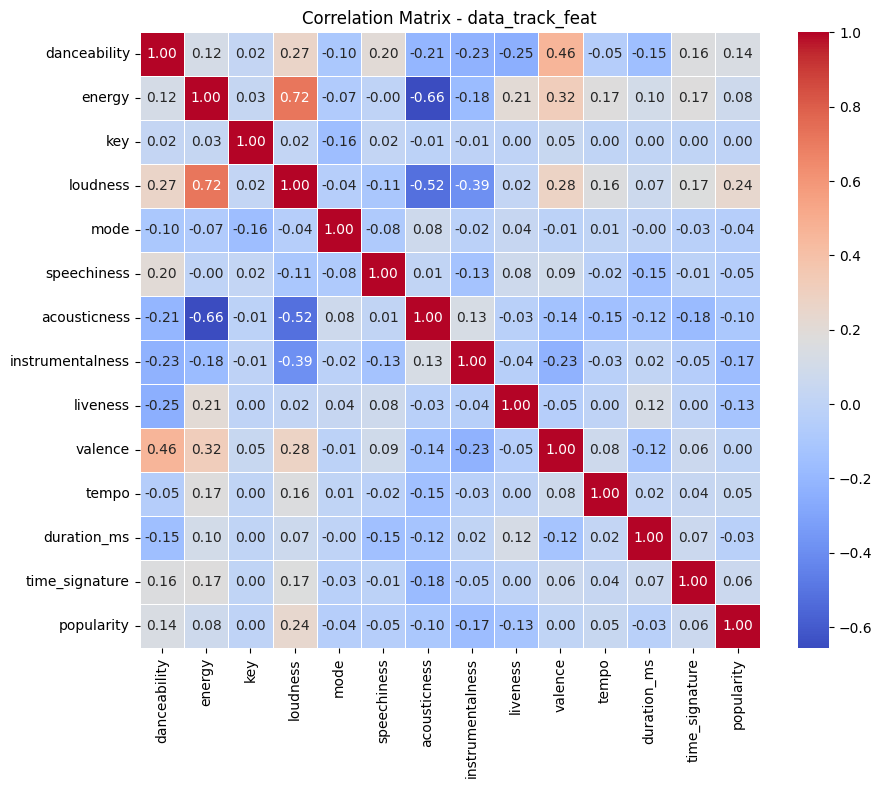

In [21]:
#Check correlation of data_track_feature

# Generate the correlation matrix
corr_matrix = corr_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Set the title of the plot
plt.title('Correlation Matrix - data_track_feat')

# Show the plot
plt.show()


In [22]:


# Standardize numerical features
scaler = StandardScaler()
numerical_features_standardized = scaler.fit_transform(corr_data)
# Convert the standardized features back to a DataFrame
numerical_features_standardized_df = pd.DataFrame(numerical_features_standardized, columns=corr_data.columns)

# Drop the 'popularity' column
numerical_features_standardized_df = numerical_features_standardized_df.drop(columns=['popularity'])

# Define the target variable (e.g., song_popularity)
target_variable = corr_data['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features_standardized_df, target_variable, test_size=0.2, random_state=42)



 # Calculate Mutual Information between features and the target variable
mutual_info_scores = mutual_info_regression(X_train, y_train)

# # Create a DataFrame to display feature names and their Mutual Information scores
mi_df = pd.DataFrame({'Feature': numerical_features_standardized_df.columns, 'Mutual_Info_Score': mutual_info_scores})

# # Sort the DataFrame by Mutual Information scores in descending order
mi_df = mi_df.sort_values(by='Mutual_Info_Score', ascending=False)

# # Display the sorted DataFrame
print("Mutual Information Scores:")
print(mi_df)


Mutual Information Scores:
             Feature  Mutual_Info_Score
11       duration_ms           0.058421
3           loudness           0.052377
10             tempo           0.036682
1             energy           0.028259
7   instrumentalness           0.027825
5        speechiness           0.026055
6       acousticness           0.025924
9            valence           0.025773
0       danceability           0.024516
8           liveness           0.021987
12    time_signature           0.005440
4               mode           0.001574
2                key           0.000337


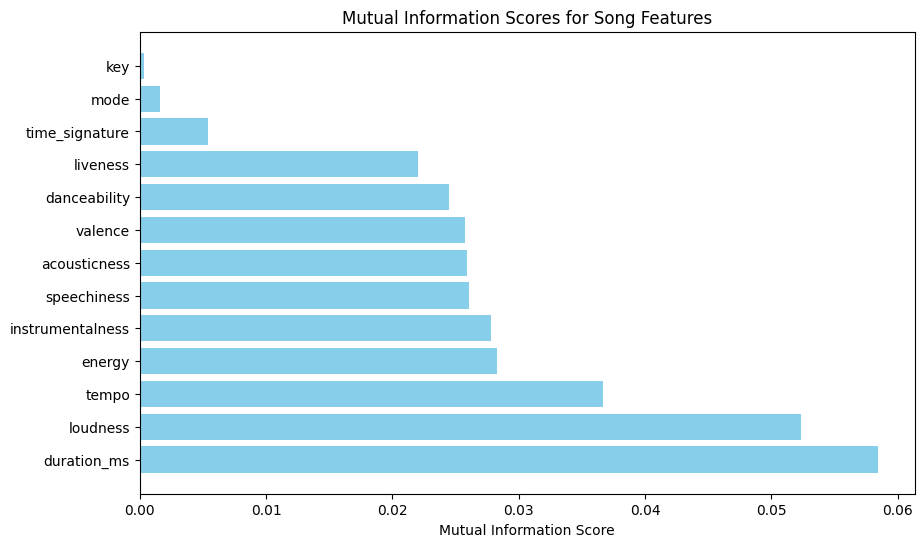

In [23]:
# Sort the DataFrame by Mutual Information scores in descending order
mi_df = mi_df.sort_values(by='Mutual_Info_Score', ascending=False)

# Visualize Mutual Information scores using a bar chart
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual_Info_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Mutual Information Scores for Song Features')
plt.show()

content-based filters — to make recommendations based on similar products/services according to their attributes.


In [6]:
class SongRecommendationSystem:
    def __init__(self, data: pd.DataFrame):

        self.song_library = data
        self.song_library = self.song_library.sort_values(by=['track_popularity'], ascending=False).reset_index(drop=True)

        # Features for recommendation (numerical + genres)
        self.features_matrix = self._create_features_matrix()

        self.nn_model = NearestNeighbors(metric='cosine')
        self.nn_model.fit(self.features_matrix)

    def _create_features_matrix(self):
        num_cols = ['track_popularity', 'artist_popularity','energy', 'danceability', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                    'time_signature']

        # CountVectorizer for genres
        genre_vectorizer = CountVectorizer()
        genre_matrix = genre_vectorizer.fit_transform(self.song_library['genres']).toarray()

        # Combine numerical and genres features
        features_matrix = pd.concat([self.song_library[num_cols], pd.DataFrame(genre_matrix)], axis=1).values

        return features_matrix

    def recommend_songs(self, track_name, num_recommendations=5):

        if track_name not in self.song_library['track_name'].values:
            print(f'Track "{track_name}" not found in the dataset.')
            return None
        track_index = self.song_library.index[self.song_library['track_name'] == track_name].tolist()[0]
        _, indices = self.nn_model.kneighbors([self.features_matrix[track_index]], n_neighbors=num_recommendations + 1)
        recommended_songs = self.song_library.loc[indices[0][1:], :]
        return recommended_songs

In [7]:
%%time
# Example usage:
sql = "SELECT * FROM home.searchs"
song = client.query(sql, options)
recommendation_system = SongRecommendationSystem(song)

CPU times: user 3.74 s, sys: 1.48 s, total: 5.22 s
Wall time: 20.8 s


In [8]:
%%time
track_name = "Yo Voy (feat. Daddy Yankee)"
recommended_songs = recommendation_system.recommend_songs(track_name)
recommended_songs

CPU times: user 641 ms, sys: 408 ms, total: 1.05 s
Wall time: 630 ms


,track_id,track_name,track_url,track_popularity,track_preview,artist_name,artist_popularity,artist_image,track_release_year,album_name,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
1189,5gflgO9EPbIBf16n5TKnQS,Yo Voy (feat. Daddy Yankee),https://open.spotify.com/track/5gflgO9EPbIBf16...,80,https://p.scdn.co/mp3-preview/0d6bcbc99daa02a5...,Zion & Lennox,74,https://i.scdn.co/image/ab6761610000e5ebfa8445...,2004,Motivando a la Yal,...,1,0.2410,0.0410,0.000000,0.0546,0.554,95.060,232020,4,"reggaeton, urbano latino, reggaeton, urbano la..."
928,6OzUIp8KjuwxJnCWkXp1uL,Besos Moja2,https://open.spotify.com/track/6OzUIp8KjuwxJnC...,81,https://p.scdn.co/mp3-preview/8b17c9ae5706f7f2...,Wisin & Yandel,76,https://i.scdn.co/image/ab6761610000e5ebb5496c...,2022,La Última Misión,...,0,0.0571,0.0584,0.000002,0.0976,0.644,94.048,229065,4,"trap latino, electro latino, reggaeton, urbano..."
138,6RUKPb4LETWmmr3iAEQktW,Something Just Like This,https://open.spotify.com/track/6RUKPb4LETWmmr3...,88,https://p.scdn.co/mp3-preview/4e117abe76700eb1...,The Chainsmokers,78,https://i.scdn.co/image/ab6761610000e5ebdb68d6...,2017,Memories...Do Not Open,...,0,0.0317,0.0498,0.000014,0.1640,0.446,103.019,247160,4,pop
666,5hM5arv9KDbCHS0k9uqwjr,Borderline,https://open.spotify.com/track/5hM5arv9KDbCHS0...,83,None,Tame Impala,77,https://i.scdn.co/image/ab6761610000e5eb90357e...,2020,The Slow Rush,...,0,0.0369,0.0406,0.000009,0.0824,0.873,97.960,237800,4,"australian psych, modern rock, rock, neo-psych..."
5667,5ArQzSBevAdXTxRY6Ulhbq,Mama Said,https://open.spotify.com/track/5ArQzSBevAdXTxR...,70,https://p.scdn.co/mp3-preview/280d3bd6a10a86a8...,Lukas Graham,69,https://i.scdn.co/image/ab6761610000e5ebd16592...,2016,Lukas Graham,...,0,0.0703,0.0447,0.000064,0.3700,0.591,83.996,206903,4,"danish pop, scandipop"


## Save to Pickle file for future use

In [9]:
import dill

with open('./recommender_model.pkl', 'wb') as file:
    dill.dump({"model_class": SongRecommendationSystem, "model": recommendation_system}, file)

In [6]:
import dill

with open('./recommender_model.pkl', 'rb') as file:
    data = dill.load(file)

model_class = data['model_class']
model = data['model']

In [7]:
name = "Last Christmas"
df = model.recommend_songs(name)
df

,track_id,track_name,track_url,track_popularity,track_preview,artist_name,artist_popularity,artist_image,track_release_year,album_name,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
654,6ZOBP3NvffbU4SZcrnt1k6,Kryptonite,https://open.spotify.com/track/6ZOBP3NvffbU4SZ...,83,None,3 Doors Down,68,https://i.scdn.co/image/ab6761610000e5eb2064b5...,2000,The Better Life,...,0,0.0286,0.00664,0.000011,0.168,0.543,99.009,233933,4,"post-grunge, alternative metal, nu metal, rock"
1006,3WkibOpDF7cQ5xntM1epyf,It Wasn't Me,https://open.spotify.com/track/3WkibOpDF7cQ5xn...,81,None,Shaggy,70,https://i.scdn.co/image/ab6761610000e5eb356dc7...,2000,Hot Shot,...,1,0.0713,0.05610,0.000000,0.313,0.654,94.759,227600,4,"reggae fusion, pop rap"
281,0COqiPhxzoWICwFCS4eZcp,Bring Me To Life,https://open.spotify.com/track/0COqiPhxzoWICwF...,86,None,Evanescence,71,https://i.scdn.co/image/ab6761610000e5eb7ecf21...,2003,Fallen,...,0,0.0698,0.00721,0.000002,0.242,0.296,94.612,235893,4,alternative metal
255,06qMRF18gwbOYYbnP2du6i,Last Christmas - Single Version,https://open.spotify.com/track/06qMRF18gwbOYYb...,86,https://p.scdn.co/mp3-preview/291b50b25994238d...,Wham!,76,https://i.scdn.co/image/ab6761610000e5eb03e73d...,2023,The Singles: Echoes from the Edge of Heaven,...,1,0.0278,0.21200,0.000004,0.156,0.935,107.732,265960,4,"new romantic, new wave, soft rock, new wave pop"
1546,5oady7OSE7dH7LHiqmb3Cr,"Dreams, Fairytales, Fantasies (feat. Brent Fai...",https://open.spotify.com/track/5oady7OSE7dH7LH...,79,https://p.scdn.co/mp3-preview/02788afc758468a9...,A$AP Ferg,68,https://i.scdn.co/image/ab6761610000e5ebf1122f...,2019,Floor Seats,...,1,0.1190,0.29200,0.000000,0.130,0.449,92.049,222987,4,"hip hop, pop rap, rap, trap, southern hip hop"


In [8]:
for row in df[['track_name','artist_name']].values:
    print(row)

['Kryptonite' '3 Doors Down']
["It Wasn't Me" 'Shaggy']
['Bring Me To Life' 'Evanescence']
['Last Christmas - Single Version' 'Wham!']
['Dreams, Fairytales, Fantasies (feat. Brent Faiyaz & Salaam Remi)'
 'A$AP Ferg']


In [1]:
!python3 --version

Python 3.11.6
